# MultiREx Autoencoder for Exoplanet Spectra Denoising (H2O)

This script trains a deep learning model to remove noise and stellar contamination
from exoplanet transit spectra. This version is fully optimized for memory efficiency
on both CPU and GPU.


## 1. Initial Setup and Imports


In [2]:
import multirex as mrex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import gc
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Numba not installed, using numpy instead
Loading MultiREx version 0.3.2


## 2. Configuration and Helper Functions


In [3]:
def remove_warnings():
    """Suppresses specified warnings for cleaner output."""
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings(
        "ignore",
        category=UserWarning,
        message="Pandas doesn't allow columns to be created via a new attribute name*",
    )
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

def configure_gpu_memory_growth():
    """Prevents TensorFlow from allocating all GPU memory at once."""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        print(f"TensorFlow memory growth set for {len(gpus)} GPU(s).")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"GPU memory growth could not be set: {e}")

# Initial setup
remove_warnings()
configure_gpu_memory_growth()

# Load and prepare wavelength data
waves = np.loadtxt("waves.txt")
n_points = len(waves)
wn_grid = np.sort((10000 / waves))


def apply_contaminations_from_files(contamination_files, df, n_points):
    """
    Applies multiple stellar contaminations to the spectral data.
    This version is optimized to prevent DataFrame fragmentation.
    """
    df_list = []
    # Add non-contaminated case
    df_no_contam = df.copy().assign(f_spot=0.0, f_fac=0.0)
    cols = ["f_spot", "f_fac"] + [col for col in df.columns if col not in ["f_spot", "f_fac"]]
    df_list.append(df_no_contam[cols])
    
    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        if not os.path.isfile(file_path): raise FileNotFoundError(f"File not found: {file_path}")
        
        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match: raise ValueError(f"Filename '{filename}' does not match pattern.")

        f_spot = float(match.group("f_spot"))
        f_fac = float(match.group("f_fac"))

        try:
            contam_data = np.loadtxt(file_path, ndmin=2)
            contam_values = contam_data[:, 1] if contam_data.shape[1] >= 2 else contam_data.flatten()
            if len(contam_values) != n_points: raise ValueError(f"Contamination values in '{filename}' != n_points.")
        except Exception as e:
            raise ValueError(f"Error reading {file_path}: {e}")

        df_contam = df.copy()
        data_columns = df_contam.columns[-n_points:]
        df_contam[data_columns] *= contam_values[::-1]
        df_contam = df_contam.assign(f_spot=f_spot, f_fac=f_fac)
        df_list.append(df_contam[cols])

    df_final = pd.concat(df_list, ignore_index=True).copy()
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]
    return df_final

def filter_rows(df):
    """Filters rows based on atmospheric composition values."""
    filter_cols = ["atm CH4", "atm O3", "atm H2O"]
    for chem in [col for col in filter_cols if col in df.columns]:
        df = df[df[chem] >= -8].copy()
    df.data = df.iloc[:, -n_points:]
    df.params = df.iloc[:, :-n_points]
    return df

def load_and_prep_data(filepath, n_points):
    """Reads a CSV and sets appropriate data types for memory efficiency."""
    df = pd.read_csv(filepath)
    df[df.columns[-n_points:]] = df[df.columns[-n_points:]].astype('float32')
    return df

def normalize_min_max_by_row(df):
    """Normalizes each row of a DataFrame to a [0, 1] range."""
    min_vals = df.min(axis=1)
    max_vals = df.max(axis=1)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Avoid division by zero
    return (df.sub(min_vals, axis=0)).div(range_vals, axis=0)

def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    """Generates a new DataFrame by applying Gaussian noise to the spectra."""
    # This function now correctly handles dataframes without .data/.params attributes
    if hasattr(df, 'data') and hasattr(df, 'params'):
        df_params = df.params
        df_spectra = df.data.astype('float32')
    else:
        # Assumes the last n_points columns are spectral data
        df_params = df.iloc[:, :-n_points]
        df_spectra = df.iloc[:, -n_points:].astype('float32')
    
    if seed is not None: np.random.seed(seed)
    
    replicated_spectra_vals = np.repeat(df_spectra.values, n_repeat, axis=0)
    
    if isinstance(noise_std, (int, float)):
        noise = np.random.normal(0, noise_std, replicated_spectra_vals.shape).astype('float32')
    else:
        noise_array = np.array(noise_std, dtype='float32')
        noise_replicated = np.tile(np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0), (1, df_spectra.shape[1]))
        noise = np.random.normal(0, noise_replicated, replicated_spectra_vals.shape).astype('float32')
        
    noisy_spectra = pd.DataFrame(replicated_spectra_vals + noise, columns=df_spectra.columns)

    replicated_params = pd.DataFrame(np.repeat(df_params.values, n_repeat, axis=0), columns=df_params.columns)
    
    target_len = len(replicated_params)
    new_cols_data = {
        "noise_std": np.full(target_len, noise_std) if isinstance(noise_std, (int, float)) else np.repeat(noise_std, n_repeat),
        "n_repeat": np.full(target_len, n_repeat)
    }
    new_cols_df = pd.DataFrame(new_cols_data)

    df_final = pd.concat([new_cols_df, replicated_params.reset_index(drop=True), noisy_spectra.reset_index(drop=True)], axis=1)
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]
    return df_final


GPU memory growth could not be set: Physical devices cannot be modified after being initialized


## 3. Load and Process Source Data


In [4]:
contamination_files = [
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt",
]

# Initialize variables to prevent NameError if try block fails
airless_data, CO2_data, H2O_data = None, None, None

try:
    # Load and apply contaminations
    temp_airless = load_and_prep_data("spec_data/airless_data.csv", n_points)
    airless_data = apply_contaminations_from_files(contamination_files, temp_airless, n_points)

    temp_CO2 = load_and_prep_data("spec_data/CO2_data.csv", n_points)
    CO2_data = apply_contaminations_from_files(contamination_files, temp_CO2, n_points)
    
    # Load H2O data instead of CH4
    temp_H2O = filter_rows(load_and_prep_data("spec_data/H2O_data.csv", n_points))
    H2O_data = apply_contaminations_from_files(contamination_files, temp_H2O, n_points)
    
    # Clean up temporary dataframes
    del temp_airless, temp_CO2, temp_H2O
    gc.collect()

except Exception as e:
    print(f"Error during data loading: {e}")


## 4. Generate Full Dataset with Caching


In [5]:
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
# Use H2O-specific filenames to avoid overwriting CH4 data
noisy_path = os.path.join(output_dir, "H2O_X_noisy_full_dataset.npy")
clean_path = os.path.join(output_dir, "H2O_X_clean_full_dataset.npy")

if os.path.exists(noisy_path) and os.path.exists(clean_path):
    print("Found cached data. Loading from disk...")
    X_noisy = np.load(noisy_path)
    X_no_noisy = np.load(clean_path)
    print("...Loading complete.")
else:
    print("Cached data not found. Generating full dataset...")
    
    list_of_noisy_arrays, list_of_clean_arrays = [], []
    snr_values = [1, 3, 6, 10, None] 

    for snr in snr_values:
        print(f"--- Processing SNR = {snr if snr is not None else 'inf'} ---")
        noise = mrex.generate_df_SNR_noise(df=CO2_data, n_repeat=1, SNR=snr)["noise"][0] if snr is not None else 0.0

        # Generate noisy data
        temp_CO2 = generate_df_with_noise_std(df=CO2_data, n_repeat=5000, noise_std=noise)
        temp_H2O = generate_df_with_noise_std(df=H2O_data, n_repeat=500, noise_std=noise)
        temp_airless = generate_df_with_noise_std(df=airless_data, n_repeat=5000, noise_std=noise)
        noisy_df = pd.concat([temp_CO2, temp_H2O, temp_airless], ignore_index=True)
        list_of_noisy_arrays.append(normalize_min_max_by_row(noisy_df.iloc[:, -n_points:]).values.astype("float32"))
        del temp_CO2, temp_H2O, temp_airless
        gc.collect()

        # Generate corresponding clean data (from the same source dataframes but with noise_std=0)
        clean_CO2 = generate_df_with_noise_std(df=CO2_data, n_repeat=5000, noise_std=0)
        clean_H2O = generate_df_with_noise_std(df=H2O_data, n_repeat=500, noise_std=0)
        clean_airless = generate_df_with_noise_std(df=airless_data, n_repeat=5000, noise_std=0)
        clean_df = pd.concat([clean_CO2, clean_H2O, clean_airless], ignore_index=True)
        list_of_clean_arrays.append(normalize_min_max_by_row(clean_df.iloc[:, -n_points:]).values.astype("float32"))
        
        # Clean up all temporary dataframes for this loop
        del noisy_df, clean_CO2, clean_H2O, clean_airless, clean_df
        gc.collect()

    X_noisy = np.concatenate(list_of_noisy_arrays, axis=0)
    X_no_noisy = np.concatenate(list_of_clean_arrays, axis=0)
    del list_of_noisy_arrays, list_of_clean_arrays
    gc.collect()
    
    print("\n--- Saving data to disk for future runs ---")
    np.save(noisy_path, X_noisy)
    np.save(clean_path, X_no_noisy)

print(f"\nFinal noisy data shape: {X_noisy.shape}")
print(f"Final clean data shape: {X_no_noisy.shape}")
assert X_noisy.shape[0] == X_no_noisy.shape[0], "Sample count mismatch."


Found cached data. Loading from disk...
...Loading complete.

Final noisy data shape: (1600000, 385)
Final clean data shape: (1600000, 385)


## 5. Build and Train Autoencoder Model


### Create Optimized TensorFlow Datasets


In [21]:
BATCH_SIZE = 64
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Create datasets on CPU to prevent VRAM overflow on initialization
with tf.device('/CPU:0'):
    X_train_noisy, X_test_noisy, X_train_clean, X_test_clean = train_test_split(
        X_noisy, X_no_noisy, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    # Create efficient TensorFlow dataset pipelines
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_noisy, X_train_clean))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_tensor_slices((X_test_noisy, X_test_clean))
    validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Clean up large NumPy arrays from RAM immediately after creating TF datasets
del X_noisy, X_no_noisy, X_train_noisy, X_train_clean
gc.collect()

print("TensorFlow datasets created and source NumPy arrays cleared from RAM.")

I0000 00:00:1754649290.666482   25166 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


TensorFlow datasets created and source NumPy arrays cleared from RAM.


### Define and Compile the Autoencoder


In [22]:
# Infer input dimension directly from the dataset specification
input_dim = validation_dataset.element_spec[0].shape[1]

input_spectrum = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(512, activation="swish")(input_spectrum)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation="swish")(encoded)

# Decoder
decoded = layers.Dense(300, activation="swish")(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = keras.Model(inputs=input_spectrum, outputs=decoded)
optimizer = Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=optimizer, loss="mae")

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 385)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 385)            │       197,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,934,373 (7.38 MB)

 Trainable params: 1,934,373 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model


In [23]:
history = autoencoder.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

# Save the model with an H2O-specific name
autoencoder.save("Models/AE_H2O.keras")
print("Model training complete and saved to AE_H2O.keras")


Epoch 1/100


I0000 00:00:1754649577.263553   28015 service.cc:152] XLA service 0x7fbf840068f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754649577.263743   28015 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-08 13:39:37.371065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754649577.976289   28015 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-08 13:39:40.165265: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3369', 32 bytes spill stores, 32 bytes spill loads

2025-08-08 13:39:40.487004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

   34/20000 ━━━━━━━━━━━━━━━━━━━━ 1:36 5ms/step - loss: 0.6386  

I0000 00:00:1754649585.569236   28015 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - loss: 0.1247 - val_loss: 0.0291
Epoch 2/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.0445 - val_loss: 0.0222
Epoch 3/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.0357 - val_loss: 0.0168
Epoch 4/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.0307 - val_loss: 0.0159
Epoch 5/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0286 - val_loss: 0.0140
Epoch 6/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0273 - val_loss: 0.0139
Epoch 7/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0262 - val_loss: 0.0123
Epoch 8/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0250 - val_loss: 0.0099
Epoch 9/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0235 - val_loss: 0.0089
Epoch 10/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0226 - val_loss: 0.0083
Epoch 11/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0217 - val_loss: 0.007

## 6. Evaluate and Visualize Results


Plotting training history...


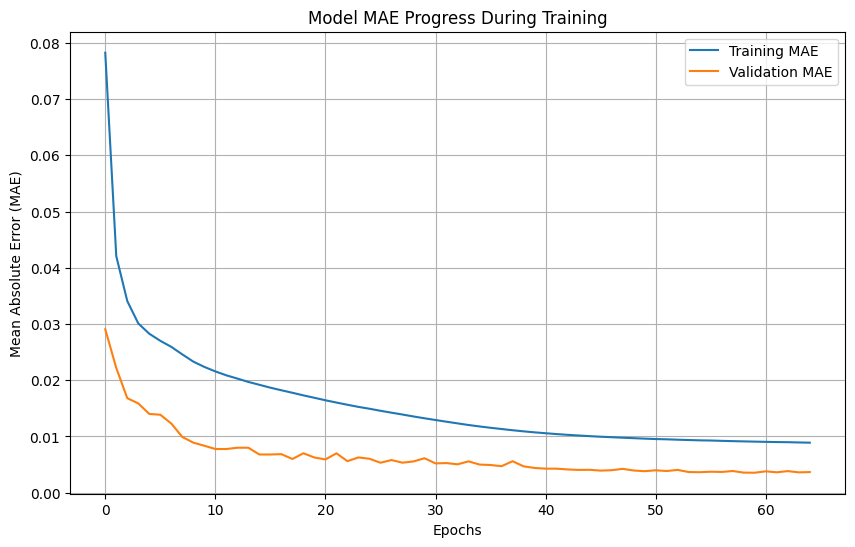


Evaluating model on test data...
Loading test data for evaluation...
Predicting on test data...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 975us/step
Visualizing sample reconstructions...


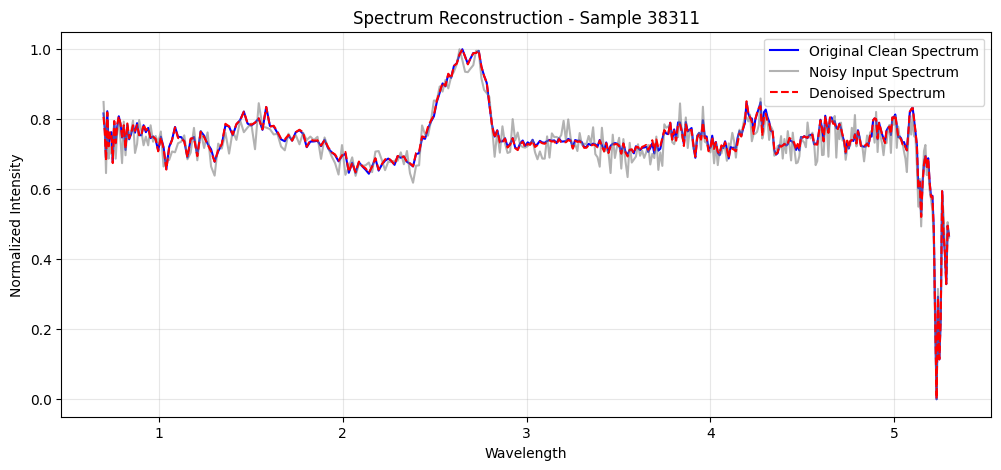

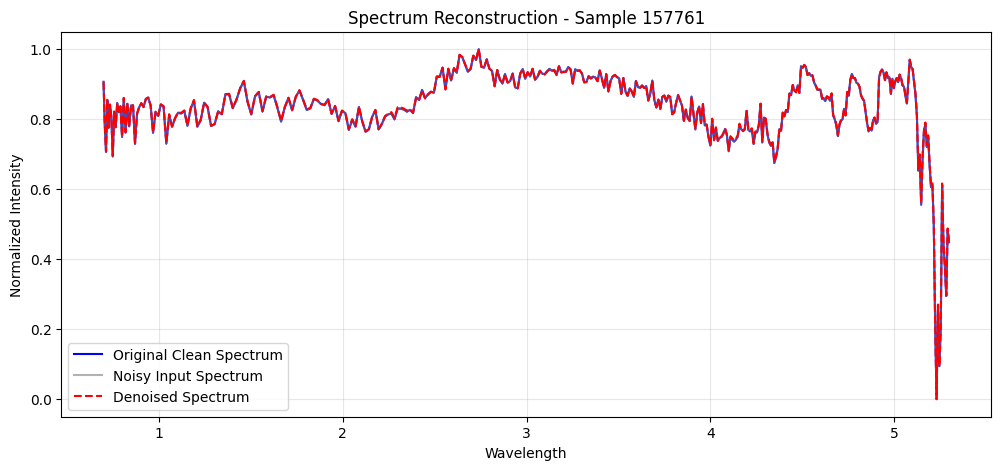

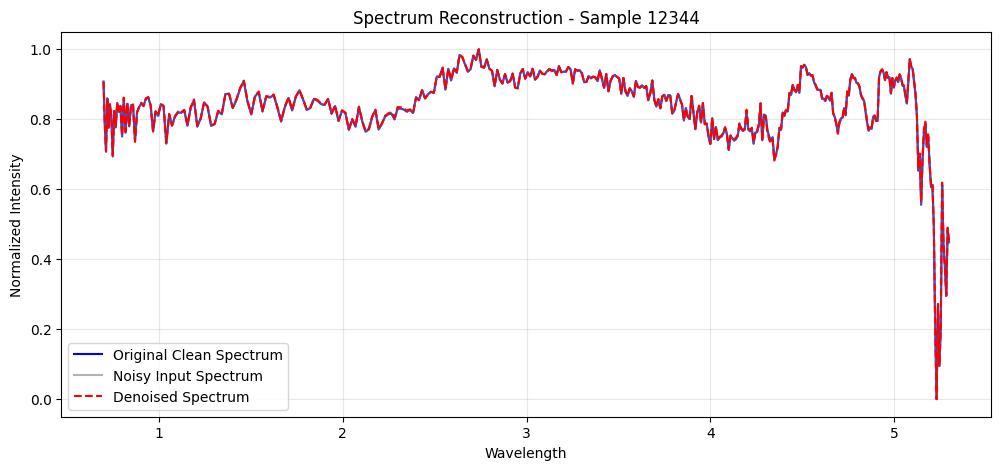

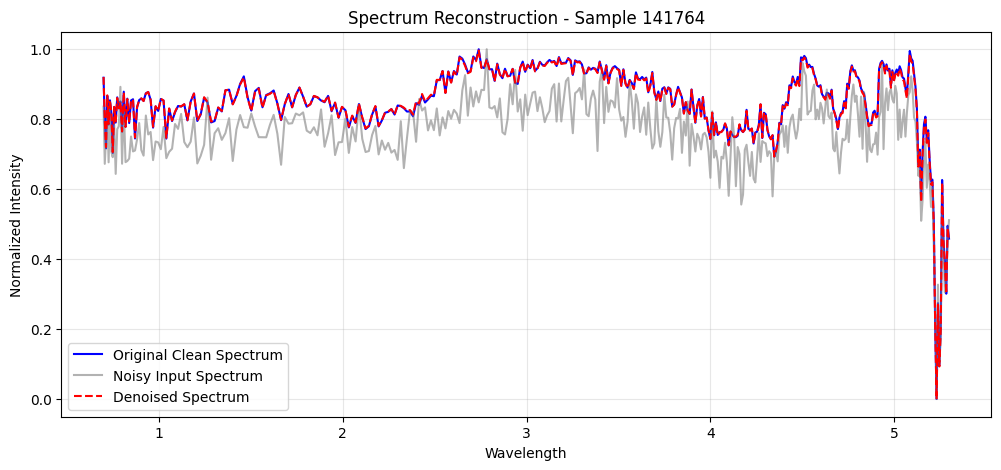

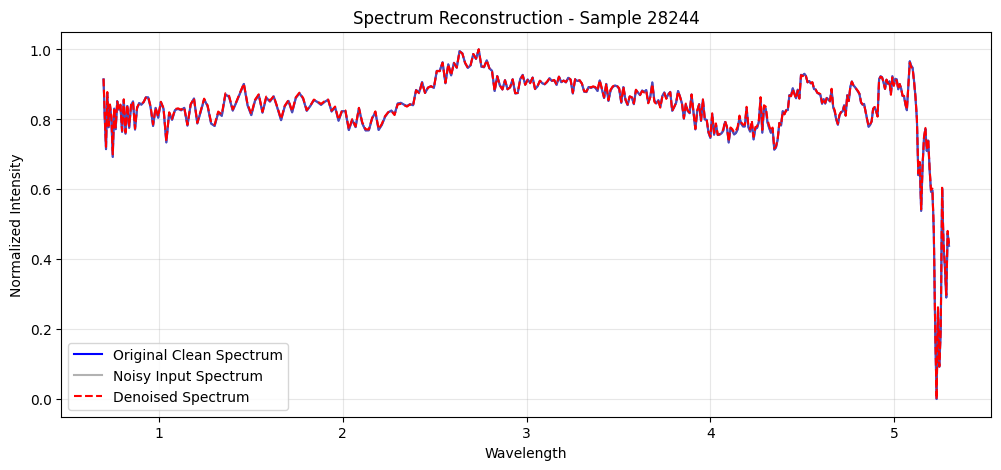

In [24]:
print("Plotting training history...")
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training MAE")
plt.plot(history.history["val_loss"], label="Validation MAE")
plt.title("Model MAE Progress During Training")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.show()

print("\nEvaluating model on test data...")
# Reload test data from cache for evaluation, as it was deleted to save RAM.
print("Loading test data for evaluation...")
# Use the H2O-specific cached filenames
noisy_path = os.path.join(output_dir, "H2O_X_noisy_full_dataset.npy")
clean_path = os.path.join(output_dir, "H2O_X_clean_full_dataset.npy")

X_noisy_full = np.load(noisy_path)
X_clean_full = np.load(clean_path)
_, X_test_noisy_eval, _, X_test_clean_eval = train_test_split(
    X_noisy_full, X_clean_full, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
del X_noisy_full, X_clean_full
gc.collect()


print("Predicting on test data...")
decoded_spectra = autoencoder.predict(X_test_noisy_eval, batch_size=BATCH_SIZE)

# Visualize a few reconstructions
print("Visualizing sample reconstructions...")
num_samples = 5
indices = np.random.choice(len(X_test_noisy_eval), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(12, 5))
    plt.plot(waves, X_test_clean_eval[idx].flatten(), label="Original Clean Spectrum", color='blue')
    plt.plot(waves, X_test_noisy_eval[idx].flatten(), label="Noisy Input Spectrum", color='gray', alpha=0.6)
    plt.plot(waves, decoded_spectra[idx].flatten(), label="Denoised Spectrum", color='red', linestyle='--')
    plt.xlabel("Wavelength")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Spectrum Reconstruction - Sample {idx}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


### Final Performance Metrics


In [25]:
print("\nCalculating final performance metrics...")
mae = mean_absolute_error(X_test_clean_eval, decoded_spectra)
print(f"Final Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean_eval, decoded_spectra)
print(f"Final Mean Squared Error (MSE): {mse:.6f}")

# Flatten for R² score
r2 = r2_score(X_test_clean_eval.flatten(), decoded_spectra.flatten())
print(f"Final Coefficient of Determination (R²): {r2:.6f}")



Calculating final performance metrics...
Final Mean Absolute Error (MAE): 0.003544
Final Mean Squared Error (MSE): 0.000189
Final Coefficient of Determination (R²): 0.997636


Loading the saved autoencoder model from AE_H2O.keras...
Model loaded successfully.

Loading test data for final evaluation...
Test data re-loaded successfully.

Predicting on test data using the saved model...


I0000 00:00:1754666070.609518    4600 service.cc:152] XLA service 0x7f0004017a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754666070.609995    4600 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-08 18:14:30.654243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754666070.762676    4600 cuda_dnn.cc:529] Loaded cuDNN version 90300


 106/5000 ━━━━━━━━━━━━━━━━━━━━ 4s 958us/step 

I0000 00:00:1754666071.047499    4600 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 916us/step

Visualizing sample reconstructions from the saved model...


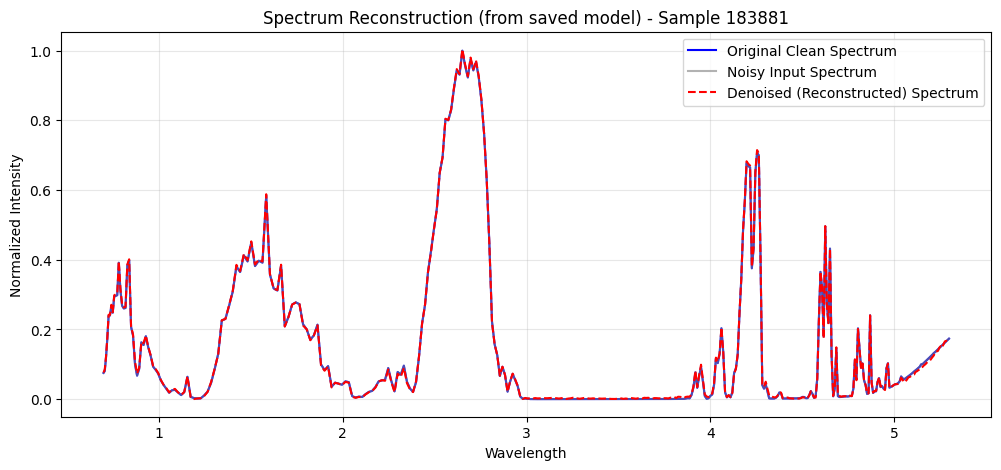

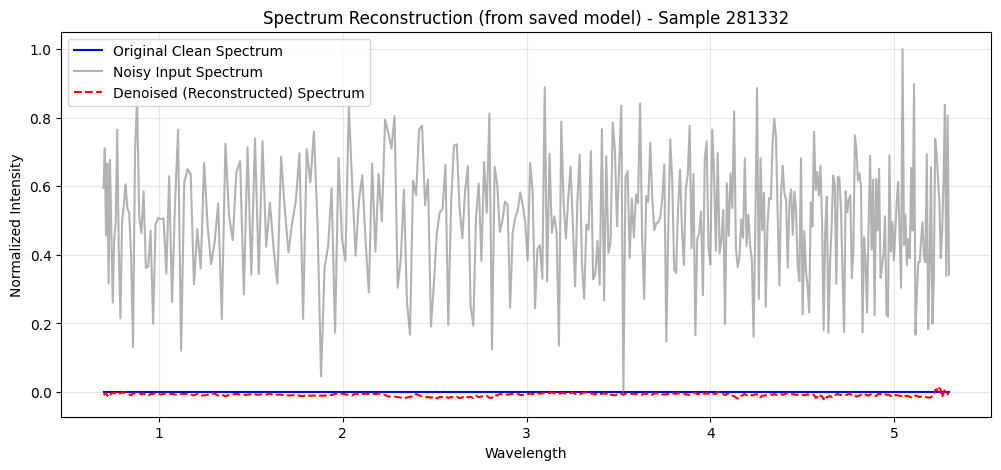

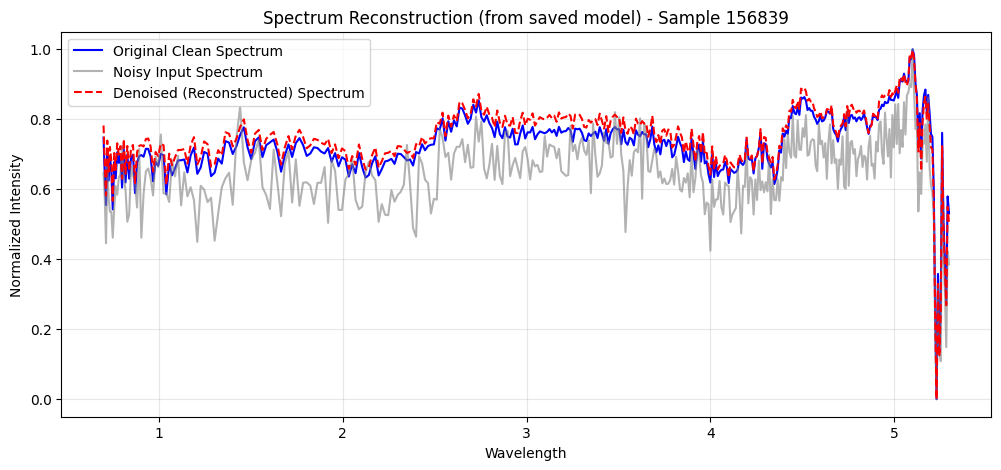

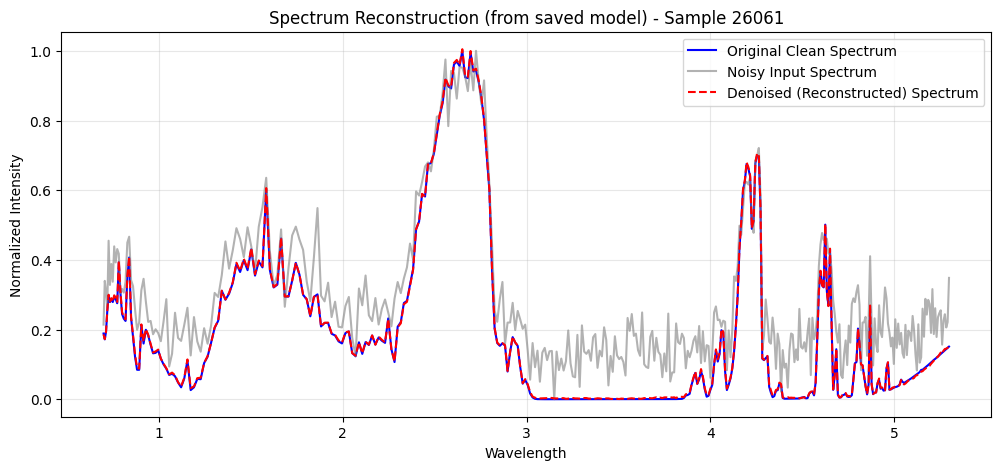

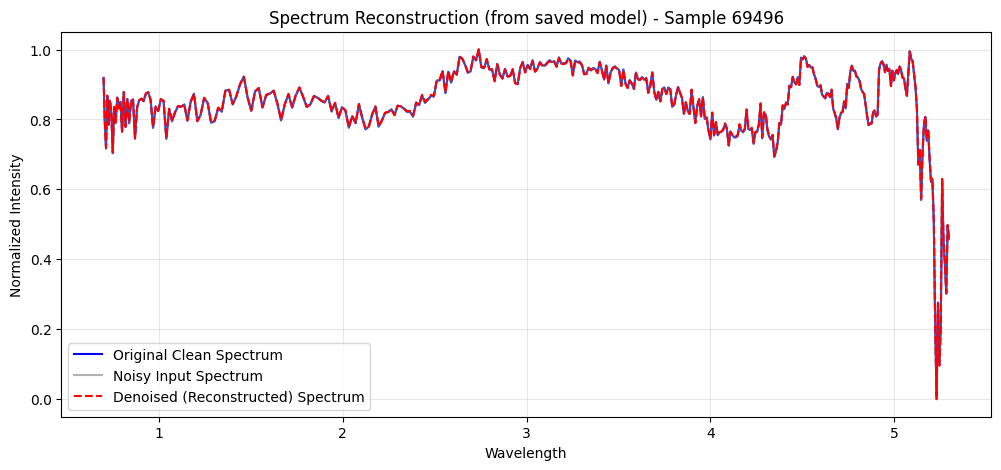


Calculating final performance metrics from the saved model...
Final Mean Absolute Error (MAE): 0.003544
Final Mean Squared Error (MSE): 0.000189
Final Coefficient of Determination (R²): 0.997636


In [6]:
from tensorflow import keras

# --- Step 1: Load the Saved Model ---
print("Loading the saved autoencoder model from AE_H2O.keras...")
saved_autoencoder = keras.models.load_model("Models/AE_H2O.keras")
print("Model loaded successfully.")


# --- Step 2: Re-load Test Data for Evaluation ---
# (This part is the same as the previous cell, ensuring we have the correct test data)
print("\nLoading test data for final evaluation...")
# Define constants again to make this cell self-contained
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64

# Ensure 'noisy_path' and 'clean_path' are defined from the caching cell
noisy_path = os.path.join(output_dir, "H2O_X_noisy_full_dataset.npy")
clean_path = os.path.join(output_dir, "H2O_X_clean_full_dataset.npy")

X_noisy_full = np.load(noisy_path)
X_clean_full = np.load(clean_path)

# Perform the exact same train-test split to get the identical test set
_, X_test_noisy, _, X_test_clean = train_test_split(
    X_noisy_full, X_clean_full, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

del X_noisy_full, X_clean_full
gc.collect()
print("Test data re-loaded successfully.")


# --- Step 3: Predict using the LOADED Model ---
print("\nPredicting on test data using the saved model...")
decoded_spectra_from_saved_model = saved_autoencoder.predict(X_test_noisy, batch_size=BATCH_SIZE)


# --- Step 4: Visualize a few reconstructions ---
print("\nVisualizing sample reconstructions from the saved model...")
num_samples = 5
indices = np.random.choice(len(X_test_noisy), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(12, 5))
    plt.plot(waves, X_test_clean[idx].flatten(), label="Original Clean Spectrum", color='blue')
    plt.plot(waves, X_test_noisy[idx].flatten(), label="Noisy Input Spectrum", color='gray', alpha=0.6)
    plt.plot(
        waves,
        decoded_spectra_from_saved_model[idx].flatten(),
        label="Denoised (Reconstructed) Spectrum",
        linestyle="--",
        color='red'
    )
    plt.xlabel("Wavelength")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Spectrum Reconstruction (from saved model) - Sample {idx}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# --- Step 5: Calculate Final Performance Metrics ---
print("\nCalculating final performance metrics from the saved model...")
mae = mean_absolute_error(X_test_clean, decoded_spectra_from_saved_model)
print(f"Final Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean, decoded_spectra_from_saved_model)
print(f"Final Mean Squared Error (MSE): {mse:.6f}")

# Flatten for R² score
r2 = r2_score(X_test_clean.flatten(), decoded_spectra_from_saved_model.flatten())
print(f"Final Coefficient of Determination (R²): {r2:.6f}")


Loading the saved autoencoder model from AE_H2O.keras...
Model loaded successfully.

Loading test data for final evaluation...
Test data re-loaded successfully.

Predicting on test data using the saved model...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step

Visualizing sample reconstructions from the saved model...


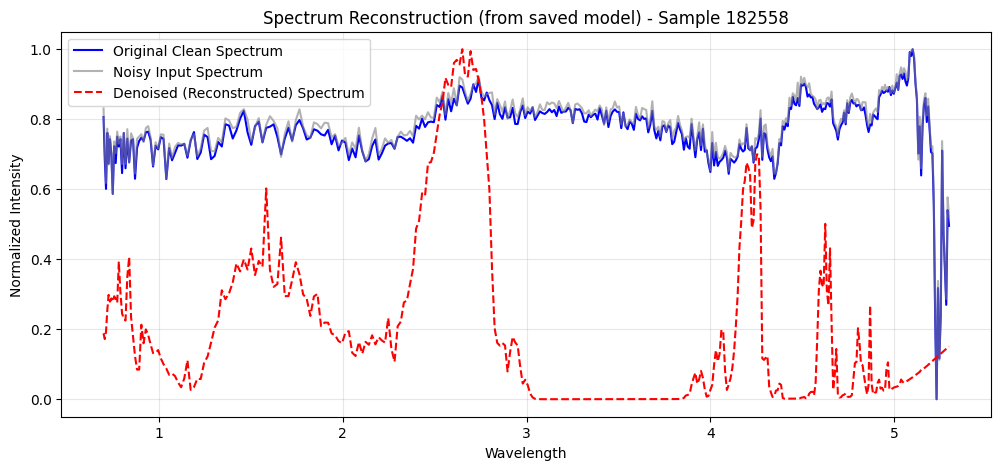

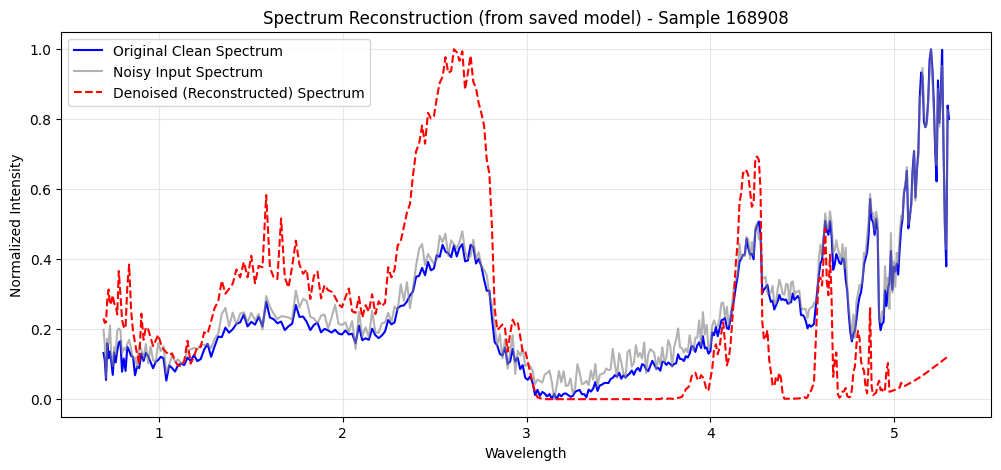

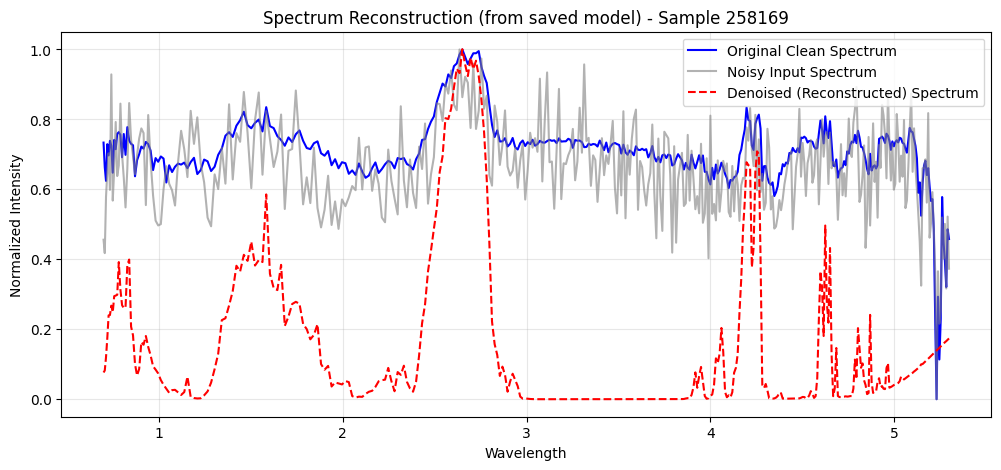

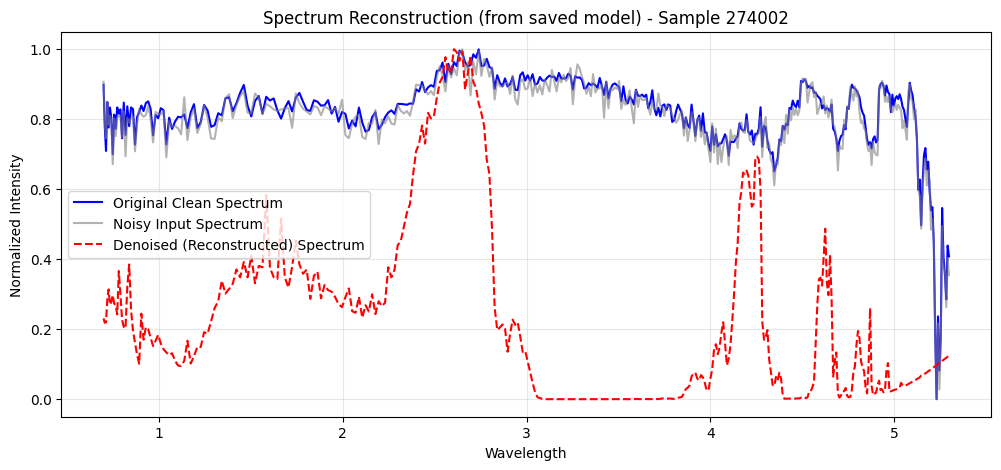

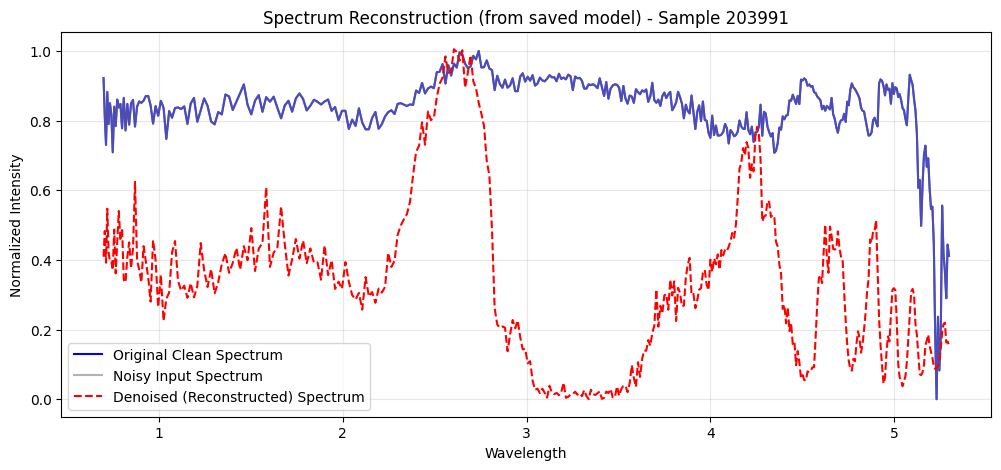


Calculating final performance metrics from the saved model...
Final Mean Absolute Error (MAE): 0.497433
Final Mean Squared Error (MSE): 0.343167
Final Coefficient of Determination (R²): -3.281035


In [ ]:
from tensorflow import keras

# --- Step 1: Load the Saved Model ---
print("Loading the saved autoencoder model from AE_H2O.keras...")
saved_autoencoder = keras.models.load_model("Models/AE_H2O_OG.keras")
print("Model loaded successfully.")


# --- Step 2: Re-load Test Data for Evaluation ---
# (This part is the same as the previous cell, ensuring we have the correct test data)
print("\nLoading test data for final evaluation...")
# Define constants again to make this cell self-contained
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64

# Ensure 'noisy_path' and 'clean_path' are defined from the caching cell
noisy_path = os.path.join(output_dir, "H2O_X_noisy_full_dataset.npy")
clean_path = os.path.join(output_dir, "H2O_X_clean_full_dataset.npy")

X_noisy_full = np.load(noisy_path)
X_clean_full = np.load(clean_path)

# Perform the exact same train-test split to get the identical test set
_, X_test_noisy, _, X_test_clean = train_test_split(
    X_noisy_full, X_clean_full, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

del X_noisy_full, X_clean_full
gc.collect()
print("Test data re-loaded successfully.")


# --- Step 3: Predict using the LOADED Model ---
print("\nPredicting on test data using the saved model...")
decoded_spectra_from_saved_model = saved_autoencoder.predict(X_test_noisy, batch_size=BATCH_SIZE)


# --- Step 4: Visualize a few reconstructions ---
print("\nVisualizing sample reconstructions from the saved model...")
num_samples = 5
indices = np.random.choice(len(X_test_noisy), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(12, 5))
    plt.plot(waves, X_test_clean[idx].flatten(), label="Original Clean Spectrum", color='blue')
    plt.plot(waves, X_test_noisy[idx].flatten(), label="Noisy Input Spectrum", color='gray', alpha=0.6)
    plt.plot(
        waves,
        decoded_spectra_from_saved_model[idx].flatten(),
        label="Denoised (Reconstructed) Spectrum",
        linestyle="--",
        color='red'
    )
    plt.xlabel("Wavelength")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Spectrum Reconstruction (from saved model) - Sample {idx}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# --- Step 5: Calculate Final Performance Metrics ---
print("\nCalculating final performance metrics from the saved model...")
mae = mean_absolute_error(X_test_clean, decoded_spectra_from_saved_model)
print(f"Final Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean, decoded_spectra_from_saved_model)
print(f"Final Mean Squared Error (MSE): {mse:.6f}")

# Flatten for R² score
r2 = r2_score(X_test_clean.flatten(), decoded_spectra_from_saved_model.flatten())
print(f"Final Coefficient of Determination (R²): {r2:.6f}")
